In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
#import GlobalAveragePooling2D, Dense, Resizing, Rescaling
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter
import tensorflow_datasets as tfds
from pathlib import Path



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
num_epochs = 24
extra_to_majority = 2000
#extra_to_majority = 5
fake_data = 0
top_dropout_rate = 0.2



class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2

undersample_test = False

In [4]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(image_ds, class_names = None, labels=None, predictions=None, confidences=None, ncols=4, scale=1.0):
  target = ncols*ncols
  actual = 0
  for image_batch, labels_batch in image_ds:
    print(image_batch.shape)
    actual+= image_batch.shape[0]
    if(actual > target):
      actual = target
      break

  plt.figure(figsize=(10, 10))
  nrows = (actual + ncols -1) // ncols
  print(actual)
  for images, labels in image_ds.take(1):
    for i in range(ncols*ncols):
      #print(i)
      ax = plt.subplot(ncols, ncols, i + 1)
      image_batch = (images[i].numpy()*scale)
      print(scale)
      print(np.min(image_batch), np.max(image_batch))
      image_batch = image_batch.astype("uint8")
      print(np.min(image_batch), np.max(image_batch))
      plt.imshow(image_batch)
      #plt.imshow(images[i])
      title= class_names[np.argmax(labels[i])]
      if(predictions):
        title+="\nPred="+str(predictions[i])
      if(confidences):
        title+="\nConf="+str(confidences[i])
      plt.title(title)

      plt.axis("off")
      if i >= actual-1:
        break
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, ds, class_names = None, num_images_to_display = 16 , scale = 1.0 ):
  #print(data_gen.class_indices)
  # plot a single image
  i=0
  for x,y in ds:
    print("Plotting x which length"+str(len(x)))
    for image, label in zip(x, y):
      label_confidence=np.max(label)
      label_index = np.argmax(label)  # Get the index of the predicted class
      # Display the image
      plt.imshow(image.numpy().astype("uint8"))
      plt.title(f"Label: {class_names[label_index]}\nConf: "+str(label_confidence))
      plt.grid(False)
      plt.show()
      i+=1
      if(i > 1):
        break
    break
  predictions = model.predict(ds)
  print(model.metrics_names)
  print("Predictions")
  print(predictions)
  sample_size = min(num_images_to_display, len(predictions))
  sample_indices = random.sample(range(len(predictions)), sample_size)
  predict_confidence = [i for i in np.max(predictions, axis=1)]
  predicted_labels = [class_names[i] for i in np.argmax(predictions, axis=1)]
  ground_truth_labels = []
  for x,y in ds:
    print("Plotting x which length"+str(len(x)))
    for image, label in zip(x, y):
      ground_truth_labels.append( class_names[np.argmax(label)] )

  # Display the images and their labels/predictions
  i_to_plot, g_to_plot, p_to_plot, c_to_plot = [],[],[],[]
  for i, idx in enumerate(sample_indices):
    g_to_plot.append(ground_truth_labels[idx])
    p_to_plot.append( predicted_labels[idx])
    c_to_plot.append(predict_confidence[idx])
  display_images_in_grid(
      ds,
      class_names=class_names,
      labels=g_to_plot,
      predictions=p_to_plot,
      confidences=c_to_plot,
      scale=scale)
  # Calculate accuracy
  print("ground")
  print(ground_truth_labels)
  print("predicted")
  print(predicted_labels)
  accuracy = accuracy_score(ground_truth_labels, predicted_labels)
  print("Accuracy: {:.2%}".format(accuracy))
  ret={}
  ret['accuracy']=accuracy
  ret['groundtruth']=ground_truth_labels
  ret['predictions']=predicted_labels
  return ret
  #f1 = f1_score(ground_truth_labels, predicted_labels)
  #print("F1: {:.2%}".format(accuracy))
  #ret['f1']=f1
  #precision = precision_score(ground_truth_labels, predicted_labels)
  #print("Precision: {:.2%}".format(precision))
  #ret['precision']=precision
  #recall = recall_score(ground_truth_labels, predicted_labels)
  #print("Recall: {:.2%}".format(recall))
  #ret['recall']=recall

def show_confusion_matrix(truth, pred, title, class_labels):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def predict_and_display_images_in_folder(folder, model, image_gen, data_gen, target_sizes,  num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  expected_classes=data_gen.class_indices.keys()
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  p_list_full = []
  t_list_full = []
  for c in expected_classes:
    i_list = []
    p_list = []
    t_list = []
    png_files = glob.glob(os.path.join(folder+"/"+c, '*.png'))
    # Loop over the PNG files
    for png_file in png_files:
      if "mask" not in os.path.basename(png_file):
        img = image.load_img(png_file, target_size=target_sizes)
        img = image.img_to_array(img)
        img = preprocess_input(img)
        #image = Image.open(png_file)
        #print(type(image))
        #print(image.shape)
        #image = image.resize(target_sizes)
        print(type(img))
        print(img.shape)
        image_array = np.array(img).astype(np.float32)/255.0

        preprocessed_image = image_gen.standardize(image_array)  # This applies rescaling and other transformations
        # Perform evaluation using your model
        predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

        i_list.append(png_file)
        p_list.append(class_labels[np.argmax(predictions)])
        t_list.append(c)
    p_list_full.extend(p_list)
    t_list_full.extend(t_list)

    display_images_in_grid(i_list[:min(len(i_list), num_images_to_display)],
                           t_list[:min(len(i_list), num_images_to_display)],
                           p_list[:min(len(i_list), num_images_to_display)])
  show_confusion_matrix(t_list_full, p_list_full, "Confusion matrix")

def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(ds, xname, class_names):
  print(class_names)
  class_counts = [0] * len(class_names)

  for _, labels in ds:
    for label in labels.numpy():
        class_counts[label] += 1
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  sns.barplot(x=class_names, y= class_counts, palette="viridis")

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

def create_datasets(data_dir, validation_split, image_size, batch_size, ignore_mask, shuffle=True ):
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=5885,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',
    labels="inferred",
    shuffle=shuffle
    )
  print("train")
  print(type(train_ds))
  print(train_ds.class_names)
  test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=5885,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',
    labels="inferred",
    shuffle=shuffle)

  class_names = train_ds.class_names

  return [train_ds, test_ds, class_names]


def undersample_list_pair(vals, labels):
  # Count the occurrences of each label in labels
  label_counts = Counter(labels)
  # Find the minimum count among label occurrences
  min_count = min(label_counts.values())
  # Undersample A and B to the minimum count for each label
  vals_undersampled = []
  labels_undersampled = []

  for label in label_counts:
    # Get the indices of elements in labels with the current label
    indices = [i for i, item in enumerate(labels) if item == label]

    # Randomly select 'min_count' indices for undersampling
    undersampled_indices = random.sample(indices, min_count)

    # Add the corresponding elements to A_prime and B_prime
    vals_undersampled.extend([vals[i] for i in undersampled_indices])
    labels_undersampled.extend([labels[i] for i in undersampled_indices])
  return [vals_undersampled, labels_undersampled]

def convert_to_one_hot(ds, num_classes):
  # Convert integer labels to one-hot encoded labels
  def one_hot_encode(labels):
    return tf.one_hot(labels, num_classes)
  # Apply one-hot encoding to the dataset
  ds = ds.map(lambda image, label: (image, one_hot_encode(label)))
  return ds

In [5]:

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake/'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2/'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32
validation_split = .2

train_ds, test_ds, class_names = create_datasets(base_directory, validation_split, image_size, batch_size, True )
train_ds_unshuffled, test_ds_unshuffled, class_names_unshuffled = create_datasets(base_directory, validation_split, image_size, batch_size, True, False )

#for image_batch, labels_batch in train_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break



Found 780 files belonging to 3 classes.
Using 624 files for training.
train
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
['benign', 'malignant', 'normal']
Found 780 files belonging to 3 classes.
Using 156 files for validation.
Found 780 files belonging to 3 classes.
Using 624 files for training.
train
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
['benign', 'malignant', 'normal']
Found 780 files belonging to 3 classes.
Using 156 files for validation.


['benign', 'malignant', 'normal']
(32, 260, 260, 3)
16
1.0
0.0 251.23077
0 251
1.0
2.0367603 255.0
2 255
1.0
0.0 254.88461
0 254
1.0
0.0 252.84052
0 252
1.0
0.0 255.0
0 255
1.0
0.2695825 255.0
0 255
1.0
0.19526577 244.46149
0 244
1.0
0.0 255.0
0 255
1.0
0.008392632 255.0
0 255
1.0
0.04399807 255.0
0 255
1.0
0.0400199 238.54926
0 238
1.0
0.0 255.0
0 255
1.0
0.048926964 255.0
0 255
1.0
0.0 228.448
0 228
1.0
0.0 254.98178
0 254
1.0
0.3343257 255.0
0 255


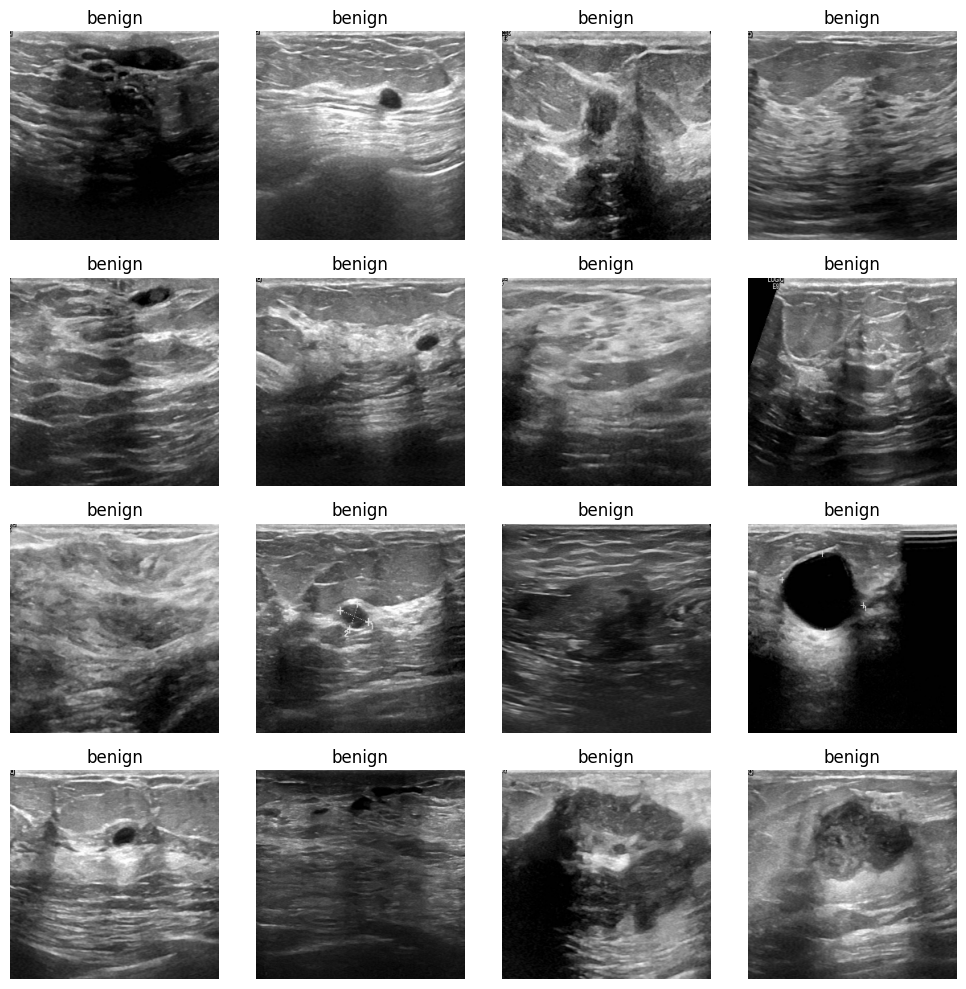

(32, 260, 260, 3)
16
1.0
0.072598815 255.0
0 255
1.0
0.0 250.46796
0 250
1.0
0.0 255.0
0 255
1.0
0.0 218.15506
0 218
1.0
0.0 243.19621
0 243
1.0
0.0 227.21321
0 227
1.0
0.0 244.73523
0 244
1.0
3.5424578 254.6988
3 254
1.0
1.2758875 254.96257
1 254
1.0
0.0 255.0
0 255
1.0
0.0 251.00479
0 251
1.0
0.0 253.46608
0 253
1.0
0.25540036 236.02649
0 236
1.0
0.0 255.0
0 255
1.0
0.13942313 255.0
0 255
1.0
0.17052557 253.78107
0 253


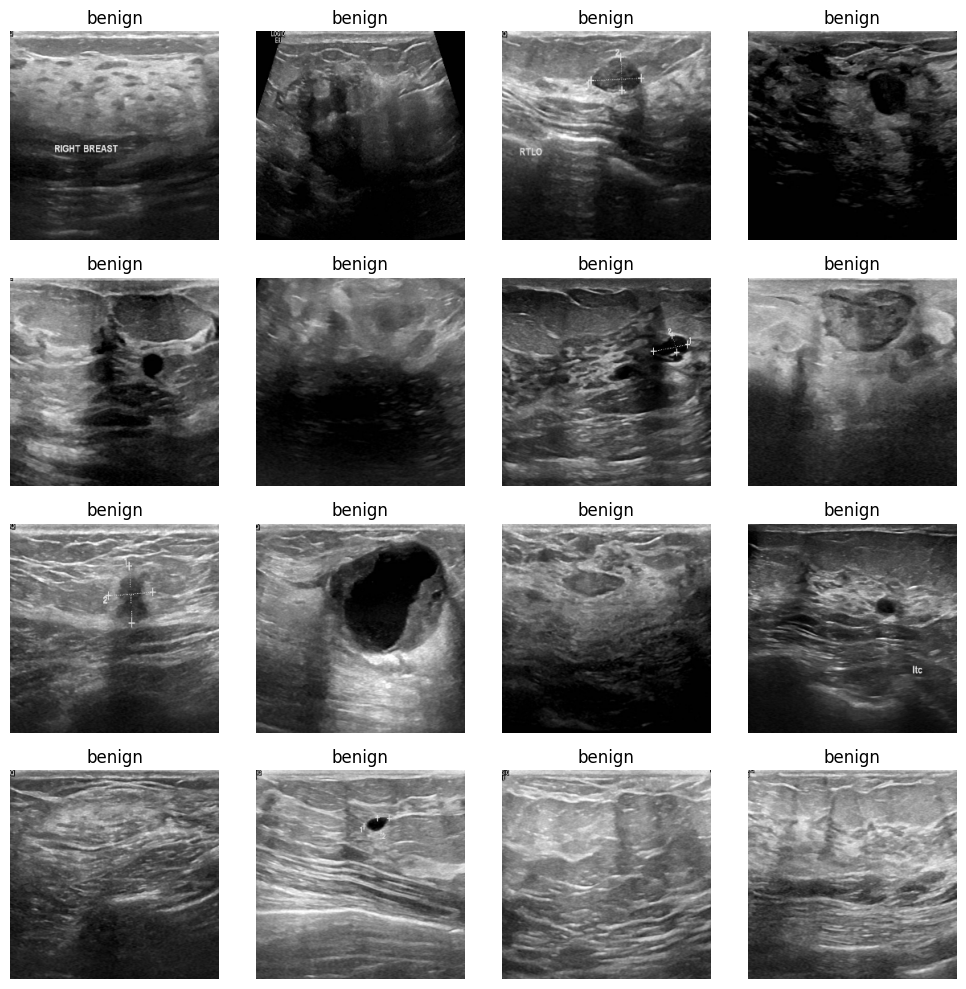

In [6]:
print(class_names)
display_images_in_grid(train_ds, class_names=class_names, ncols=4)
display_images_in_grid(test_ds, class_names=class_names, ncols=4)


0.0 255.0
0.0 255.0
(32, 260, 260, 3)
16
255.0
0.0 254.86838
0 254
255.0
0.25161096 255.0
0 255
255.0
0.0 254.94179
0 254
255.0
0.0 251.018
0 251
255.0
0.1961112 255.0
0 255
255.0
0.0 250.30513
0 250
255.0
0.0 246.6904
0 246
255.0
0.0 254.99892
0 254
255.0
1.0841347 251.47595
1 251
255.0
0.0 255.0
0 255
255.0
0.0 248.94016
0 248
255.0
0.0 254.77563
0 254
255.0
0.054733943 254.86105
0 254
255.0
0.0 245.3596
0 245
255.0
15.788484 226.6571
15 226
255.0
0.0 255.0
0 255


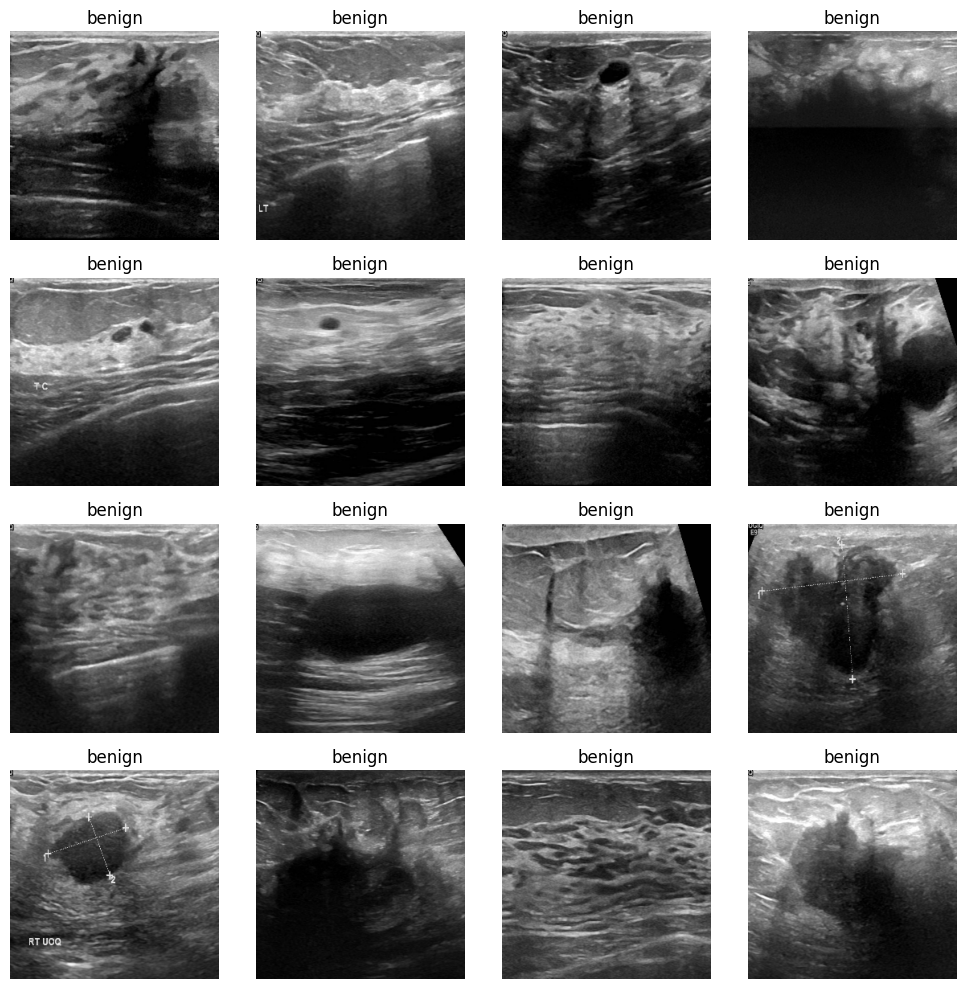

(32, 260, 260, 3)
16
255.0
0.0 255.0
0 255
255.0
0.11535645 221.44685
0 221
255.0
0.0 254.19017
0 254
255.0
0.0 227.21323
0 227
255.0
2.806875 254.99544
2 254
255.0
0.0 236.21626
0 236
255.0
0.0 255.0
0 255
255.0
0.0 255.0
0 255
255.0
0.0 229.42514
0 229
255.0
0.45349342 255.0
0 255
255.0
0.024032593 255.0
0 255
255.0
0.65748847 255.0
0 255
255.0
2.4114993 255.0
2 255
255.0
0.19748533 255.0
0 255
255.0
0.07259882 255.0
0 255
255.0
0.0 254.6771
0 254


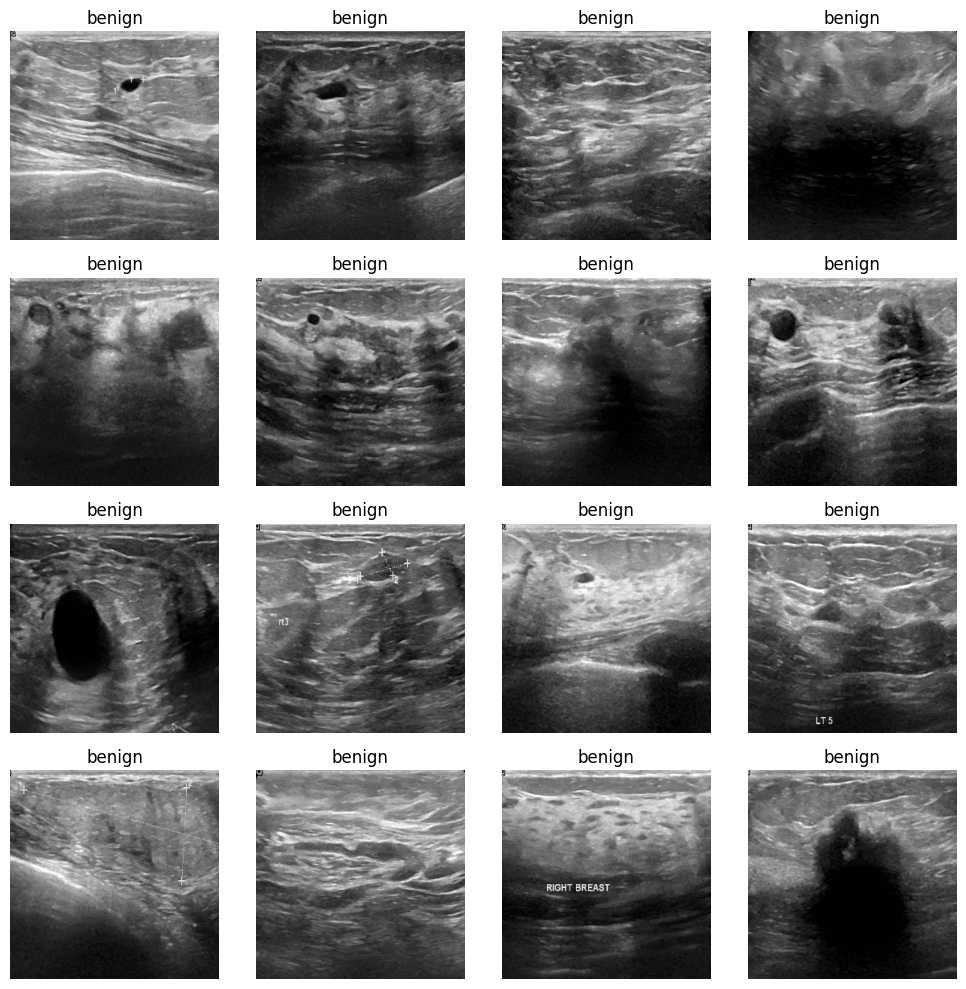

In [7]:
image_batch, labels_batch = next(iter(train_ds))
print(np.min(image_batch[0]), np.max(image_batch[0]))

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size[0], image_size[1]),
  layers.Rescaling(1./255)
])

train_ds_resized = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds_resized = test_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(train_ds))
print(np.min(image_batch[0]), np.max(image_batch[0]))
display_images_in_grid(train_ds_resized, class_names=class_names,ncols=4, scale=255.)
display_images_in_grid(test_ds_resized, class_names=class_names,ncols=4, scale=255.)

['benign', 'malignant', 'normal']


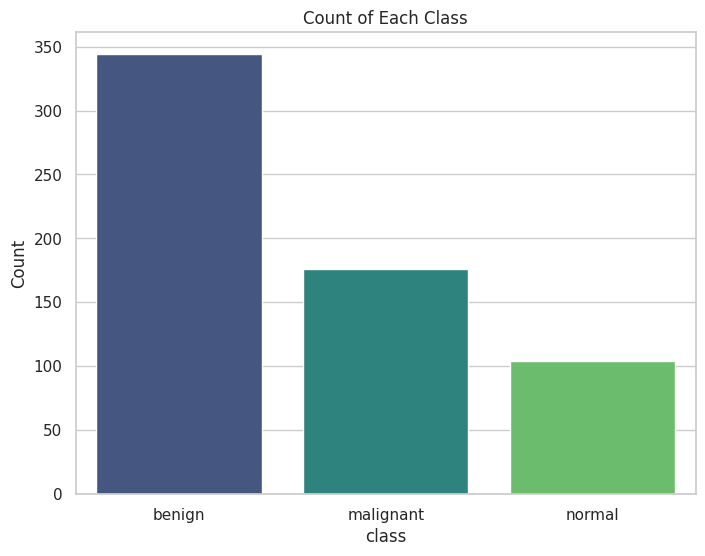

['benign', 'malignant', 'normal']


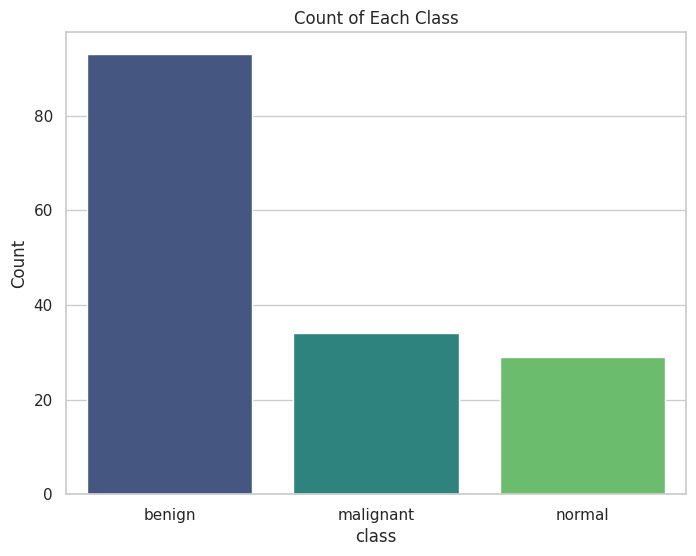

In [8]:
plot_class_counts(train_ds, "class", class_names)
plot_class_counts(test_ds, "class", class_names)


In [9]:
num_classes = 3
base_model = None
if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()

  model = tf.keras.Sequential([
      resize_and_rescale,
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      layers.RandomContrast(0.2),
      layers.RandomZoom(0.2),
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(top_dropout_rate, name="top_dropout"),
      layers.Dense(num_classes, activation='softmax')
  ])

# Specify the input shape for the first layer
model.build(input_shape=(batch_size, image_size[0], image_size[1], 3))
#  x = base_model.output
#  x = tf.keras.layers.GlobalAveragePooling2D()(x)
#  x = tf.keras.layers.BatchNormalization()(x)
#  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

#model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 260, 260, 3)       0         
                                                                 
 random_flip (RandomFlip)    (32, 260, 260, 3)         0         
                                                                 
 random_rotation (RandomRot  (32, 260, 260, 3)         0         
 ation)                                                          
                                                                 
 random_contrast (RandomCon  (32, 260, 260, 3)         0         
 trast)                                                          
                                                                 
 random_zoom (RandomZoom)    (32, 260, 260, 3)         0         
                                                                 
 efficientnet-b2 (Functiona  (None, 9, 9, 1408)       

In [10]:
print("train")
for x in train_ds:
  print([len(a) for a in x])
  i = 0
  for a in x:
    print(np.shape(a))
    i+=1
    if i> 1:
      print(a)
print("test")
for x in test_ds:
  print([len(a) for a in x])

  i = 0
  for a in x:
    print(np.shape(a))
    i+=1
    if i> 1:
      print(a)

train_ds_onehot = convert_to_one_hot(train_ds, num_classes)
test_ds_onehot = convert_to_one_hot(test_ds, num_classes)
print("train")
for x in train_ds_onehot:
  print([len(a) for a in x])
  i = 0
  for a in x:
    print(np.shape(a))
    i+=1
    if i> 1:
      print(a)
print("test")
for x in test_ds_onehot:
  print([len(a) for a in x])
  i = 0
  for a in x:
    print(np.shape(a))
    i+=1
    if i> 1:
      print(a)


train
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([1 1 2 1 0 1 0 0 2 0 0 0 2 1 2 0 0 0 1 0 2 2 0 0 2 1 2 0 0 1 0 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([2 2 0 0 0 0 0 0 1 1 0 0 2 0 0 0 0 1 1 2 1 0 1 0 1 2 0 1 0 2 0 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([0 0 0 0 0 0 2 2 0 0 0 0 2 2 0 1 0 0 0 1 1 0 2 0 2 1 1 2 0 2 2 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([0 0 0 0 0 0 0 0 2 0 0 2 0 1 0 0 1 0 1 0 1 2 1 0 2 1 1 0 1 0 0 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([0 0 0 0 1 1 2 1 2 0 1 0 1 0 0 0 0 1 2 0 0 0 1 0 1 0 0 0 2 0 1 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([0 1 0 0 1 1 1 0 0 2 0 0 2 0 0 2 0 0 0 1 2 0 0 0 0 0 0 0 0 2 1 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor([1 0 1 0 1 1 0 0 0 0 2 0 1 2 1 0 2 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0], shape=(32,), dtype=int32)
[32, 32]
(32, 260, 260, 3)
(32,)
tf.Tensor

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
best_model = 'best_model_mod'+str(image_size[0])+'.h5'
model_checkpoint = ModelCheckpoint(best_model, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train your model and use the callbacks
history = model.fit(
    train_ds_onehot,
    epochs=num_epochs,

    validation_data=test_ds_onehot,
    callbacks=[model_checkpoint, early_stopping, lr_scheduler],
    verbose=1,  # Set verbose to 1 to display training progress,
)
model.load_weights(best_model)


Epoch 1/24
20/20 [==============================] - ETA: 0s - loss: 1.6274 - accuracy: 0.4856 
Epoch 1: val_loss improved from inf to 0.83130, saving model to best_model260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 416s 19s/step - loss: 1.6274 - accuracy: 0.4856 - val_loss: 0.8313 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/24
18/20 [==========================>...] - ETA: 32s - loss: 0.9430 - accuracy: 0.6806

In [ ]:


# Assuming you've trained your model and have the `history` object
# The `history` object typically contains 'loss' and 'val_loss' values

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

train_ds_unshuffled_onehot = convert_to_one_hot(train_ds_unshuffled, num_classes)
test_ds_unshuffled_onehot = convert_to_one_hot(test_ds_unshuffled, num_classes)

In [ ]:
test_ds_onehot.shuffle=False
results=predict_and_display_images_in_grid(model, test_ds_unshuffled_onehot, class_names, scale=1.)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))

In [ ]:
results_training=predict_and_display_images_in_grid(model, train_ds_unshuffled_onehot, class_names);
ground_truth_labels_training=results_training['groundtruth']
predicted_labels_training=results_training['predictions']

print(len(ground_truth_labels_training))
print(len(predicted_labels_training))

In [ ]:

show_confusion_matrix(ground_truth_labels, predicted_labels, "Confusion Matrix (Test Data)", class_names)
show_confusion_matrix(ground_truth_labels_training, predicted_labels_training, "Confusion Matrix (Training Data)", class_names)

In [ ]:
def eval_ds(ds, num_classes):
  metrics = model.evaluate(ds)
  print(model.metrics_names)
  print(metrics)
  predictions = model.predict(ds)
  truth = []
  raw_truth = []
  for x,y in ds:
    truth.append(class_names[i] for i in np.argmax(y, axis=1))
    raw_truth.append(y)
  predicted_labels = [class_names[i] for i in np.argmax(predictions, axis=1)]
  print("Predicted Labels")
  print(predicted_labels)
  print("Truth Labels")
  for x in truth:
    print(x)
  print("Raw Predictions")
  print(predictions)
  print("Raw Truth")
  print(raw_truth)


print("Test OneHot")
eval_ds(test_ds_onehot,num_classes)
print("Test OneHot Unshuffled")
eval_ds(test_ds_unshuffled_onehot,num_classes)
print("Train OneHot Unshuffled")
eval_ds(train_ds_unshuffled_onehot,num_classes)
